# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
class FileLoader:
    def __init__(self,path,File=None,names=['text','label']):
        self.path = self.__load_path(path)
        self.names = names
        self.__load_data(File)
        
    def __load_path(self,path):
        import os
        if os.path.exists(path):
            return path
        else:
            print("Path not exist!")
    
    def __load_datum(self,files_name):
        import os
        full_path = self.path +'/'+files_name.strip().strip('/')
        if os.path.exists(full_path):
            return pd.read_csv(full_path,header=None,names=self.names)
        else:
            print("File not exist!")
            
    def __load_data(self,File):
        if File==None:
            self.train = self.__load_datum('train.csv')
            self.test = self.__load_datum('test.csv')
            self.dev = self.__load_datum('dev.csv')
            print('Finish loading:\n\ttrain.csv\n\ttest.csv\n\tdev.csv')
        else:
            self.data = self.__load_datum(File)
            print('Finish loading:\n\t'+File)

# Load dataset         
Data = FileLoader('data_sentiment')
data_tr = Data.train
data_te = Data.test
data_dev = Data.dev

Finish loading:
	train.csv
	test.csv
	dev.csv


If you use Pandas you can see a sample of the data.

In [3]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# transform test to list, and label to numpy arrays
def transform(df):
    return list(df['text']), df['label'].to_numpy().reshape(-1,1)

X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    """N-gram extraction from a document.

    Args:
        x_raw: a string corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        vocab: a given vocabulary. It should be used to extract specific features.

    Returns:
        A list of terms to the corresponding N-gram. Each part fits one N-gram,
        except 1-gramrow. For example:

        ['great','movie','watch',
        ('great', 'movie'),('movie', 'watch'),
        ('great', 'movie', 'watch')]

    """
    
    def finder(s,n):
        if n <= 0 or n > len(s):
            raise Exception('n is out of range')
        if n == 1:
            return s
        else:
            return map(lambda i: tuple(s[i:i+n]),range(len(s)-n+1))

    # Find all words by condition
    pattern = re.compile(token_pattern)
    term_eligible = [term.lower() for term in pattern.findall(x_raw) if term.lower() not in stop_words]

    # Find combinations of different N-grams
    x = [term for n in range(ngram_range[0],ngram_range[1]+1) for term in finder(term_eligible,n)]
    
    if not vocab:    
        return x
    else:
        return [term for term in x if term in vocab]

In [7]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [8]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    '''1. create a vocabulary of ngrams
       2. count the document frequencies of ngrams
       3. their raw frequency

    Args:
        X_raw: a list of strings each corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        min_df: keep ngrams with a minimum document frequency.
        keep_topN: keep top-N more frequent ngrams.

    Returns:
        vocab: a set of the n-grams that will be used as features.
        df: a Counter (or dict) that contains ngrams as keys and their corresponding
            document frequency as values.
        ngram_counts: counts of each ngram in vocab

    '''
    
    bag_of_ngrams = list()
    df = Counter()
    for line in X_raw:
        ngrams = extract_ngrams(line,ngram_range=(1,3),token_pattern=token_pattern,stop_words=stop_words)
        bag_of_ngrams += ngrams
        df.update(set(ngrams))
    df = Counter({k:v for k,v in df.items() if v >=min_df})
    ngram_counts = Counter(bag_of_ngrams)
    
    vocab = [items[0] for items in ngram_counts.most_common() if items[0] in df.keys()][:keep_topN]

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['film', 'but', 'one', 'movie', 'not', 'all', 'there', 'like', 'so', 'out', 'about', 'more', 'up', 'when', 'their', 'some', 'just', 'if', 'into', 'him', 'even', 'only', 'no', 'than', 'time', 'good', 'most', 'story', 'would', 'much', 'character', 'also', 'get', 'two', 'well', 'characters', 'other', 'very', 'first', 'see', 'after', 'because', 'way', 'make', 'off', 'plot', 'while', 'had', 'any', 'too', 'little', 'life', 'films', 'does', 'where', 'people', 'then', 'how', 'me', 'really', 'man', 'scene', 'my', 'never', 'bad', 'being', 'over', 'best', 'don', 'scenes', 'doesn', 'many', 'new', 'know', 'director', 'here', 'action', 'such', 'great', 'through', 'movies', 're', 'love', 'another', 'made', 'go', 'big', 'end', 'seems', 'something', 'still', 'back', 'world', 'us', 'work', 'now', 'down', 'before', 'makes', 'however']

[('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [11]:
# Calculate the vocab and df of different data sets
vocab_tr, df_tr, ngram_counts_tr = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
vocab_te, df_te, ngram_counts_te = get_vocab(X_te_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(X_dev_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
# create reference
id2vocab_tr = dict(enumerate(vocab_tr))
vocab2id_tr = dict(zip(id2vocab_tr.values(),id2vocab_tr.keys()))

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [12]:
# extract n-grams
X_tr_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_tr_raw]
X_te_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_te_raw]
X_dev_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_dev_raw]

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [13]:
def vectorise(X_ngram, vocab):
    
    '''1. select the features of vocab from X_ngram.
       2. convert X_ngram into matrix

    Args:
        X_ngram(list of list): a list of texts (documents) features(Bag-of-ngram)
        vocab(list): a set of selected features(n-grams)

    Returns:
        X_vec: an array shapes (#document,#vocab), where document is a single line
            in dataset.
    '''

    X_vec = np.zeros([len(X_ngram),len(vocab)])
    for docs_index in range(len(X_ngram)):
        temp = Counter(X_ngram[docs_index])
        for feature_index in range(len(vocab)):
            X_vec[docs_index,feature_index] = temp.get(vocab[feature_index],0)
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [14]:
X_tr_count = vectorise(X_tr_ngram, vocab_tr)
X_te_count = vectorise(X_te_ngram, vocab_tr)
X_dev_count = vectorise(X_dev_ngram, vocab_tr)

In [15]:
X_tr_count.shape

(1400, 5000)

In [16]:
X_tr_count[:2,:50]

array([[20.,  6.,  8.,  0.,  4.,  1.,  1.,  0.,  3.,  1.,  1.,  1.,  0.,
         0.,  6.,  1.,  2.,  1.,  2.,  0.,  3.,  4.,  1.,  1.,  0.,  1.,
         4.,  2.,  3.,  1.,  3.,  0.,  0.,  1.,  0.,  4.,  0.,  0.,  2.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  2.,  1.,  0.],
       [ 6.,  2.,  5.,  0.,  2.,  4.,  2.,  3.,  3.,  2.,  2.,  3.,  4.,
         0.,  0.,  2.,  0.,  2.,  2.,  5.,  0.,  0.,  1.,  3.,  2.,  1.,
         2.,  2.,  1.,  1.,  5.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  2.,  1.,  0.,  2.,  3.,  0.,  1.,  0.]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [17]:
def get_idfs(vocab,df,D):
    
    '''1. Accumulate the df of each word
       2. Calculate the corresponding idf by formula
       
    Returns:
        idfs: an array shapes #vocab
    '''
    
    idfs = np.zeros(len(vocab))
    for i in range(len(vocab)):
        idfs[i] = max(df[vocab[i]],1)
    idfs = np.log10(D/idfs)
    #idfs = np.log(D/idfs)
    return idfs

idfs_tr = get_idfs(vocab_tr,df_tr,len(X_tr_raw))
idfs_te = get_idfs(vocab_tr,df_te,len(X_te_raw))
idfs_dev = get_idfs(vocab_tr,df_dev,len(X_dev_raw))

Then transform your count vectors to tf.idf vectors:

In [18]:
X_tr_tfidf = X_tr_count*idfs_tr
X_te_tfidf = X_te_count*idfs_te
X_dev_tfidf = X_dev_count*idfs_dev

In [19]:
X_tr_tfidf[1,:50]

array([0.3352199 , 0.04194441, 0.25130791, 0.        , 0.15588435,
       0.39229945, 0.2531927 , 0.38353118, 0.37854406, 0.22540856,
       0.28361332, 0.38728409, 0.55011146, 0.        , 0.        ,
       0.32320144, 0.        , 0.34692489, 0.36468042, 1.24525516,
       0.        , 0.        , 0.21927133, 0.55839959, 0.40923321,
       0.22967409, 0.43239695, 0.52266534, 0.25626631, 0.24195367,
       1.37569611, 0.26818108, 0.26076682, 0.2699102 , 0.        ,
       0.        , 0.25794854, 0.        , 0.        , 0.30664999,
       0.        , 0.34472433, 0.59341724, 0.29609478, 0.        ,
       0.67313664, 0.94469503, 0.        , 0.32395996, 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [20]:
def sigmoid(z):
    
    '''Calculate sigmod results
    
    In order to avoid data overflow, the corresponding data boundary is added.
    Since np.exp() is a `np.float64` operation function, so we need to avoid overflow.
    It is easy to find out the boundary of `np.float64` by calling np.finfo(np.float64).
    Usually, it should be written as `np.minimum(np.exp(z),np.finfo(np.float64).max)`,
    but I prefer to written inside the exp function, since it somehow can be faster.
    For the input of np.exp(), it should not be greater than 709.782 to ensure that the
    output will not overflow.
    
    Returns:
        z: the same size of z.
    '''
    
    # z = 1 / (1+ np.minimum(np.exp(z),np.finfo(np.float64).max))
    z = 1 / (1 + np.exp(np.minimum(-z,709.782)))
    
    return z

In [21]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [22]:
def predict_proba(X, weights):
    
    # Get the output by mutipling x * w.T
    preds_proba = X.dot(weights.T)
    
    # Verify the size of the data
    assert preds_proba.shape == (X.shape[0],1)
    
    return sigmoid(preds_proba)

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [23]:
def predict_class(X, weights):
    
    '''1. Calculate the probability
       2. Classify according to probability
        
    Args:
        preds_proba: Probability of each data, the same
            size of input data.(X.shape[0])

    Returns:
        preds_class: The classification corresponding
            to the input data, the size is consistent
            with the amount of input data.(X.shape[0])
    '''
    
    preds_proba = predict_proba(X, weights)
    preds_class = np.where(preds_proba>=0.5,1,0)
    
    # Verify the size of the data
    assert preds_class.shape == (X.shape[0],1)
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [24]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    '''1. Calculate the probability
       2. Calculate the Euclidean distance between label and probability
       3. Calculate the average distance
       
    Here I use `esp` to represent the smallest data unit of the data type. 
    The main function of `esp` is to ensure the rationality of arithmetic 
    operations. For example, in the division operation, add `esp` to the 
    denominator to ensure that the denominator is not 0, and it does not 
    affect the data result. This is the habit I developed when I wrote Matlab
    in my undergraduate period. `esp` is more common in Matlab.
    
    Args:
        eps: the minimum value in the current data type. Used to ensure
            that the input of the log function is greater than 0.
        preds_proba: Probability of each data, the same
            size of input data.(X.shape[0])

    Returns:
        l: Used to save losses and calculate the average at the end
    '''
    
    eps = np.finfo(np.float64).eps
    preds_proba = predict_proba(X, weights)
    l = -1*(Y*np.log10(preds_proba+eps) + (1-Y)*np.log10(1-preds_proba+eps)) + alpha*np.multiply(weights, weights)
    l = np.mean(l)
    # Verify the size of the data
    assert l.shape == (1,1) or type(l) == np.float64

    return l

In [25]:
def gradient(X, y, weights, alpha=0.00001):
    
    '''Only calculate the gradient of the corresponding position
    
    Args: 
        m: the total number of the dataset sample.
        h: an numpy array of prediction corresponding to the
            dataset points. Shape (#dataset,1)
            
    Returns:
        dw: the corresponding gradient. Shape the same with 
            weight.
    '''
    
    m = len(X)
    h = predict_proba(X, weights)
    dw = np.dot((h - y).T,X) + 2*alpha*weights
    # Verify the size of the data
    assert dw.shape == weights.shape
    return dw/m

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [26]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # Stage 1: Init weights
    weights = np.zeros((1,X_tr.shape[1]))
    
    # Stage 2: Init stochastic index
    idx_list = np.array(range(X_tr.shape[0]))
    
    # Stage 3: Training
    for epoch in range(epochs):
        loss_tr = 0
        np.random.shuffle(idx_list) # disorder dataset
        
        for i in idx_list:
            X_tr_i, Y_tr_i = X_tr[i].reshape(1,-1),Y_tr[i].reshape(1,-1) # get a single data pair
            dw = gradient(X_tr_i, Y_tr_i, weights, alpha) # gradient
            weights -= lr*dw # update
            loss_tr += binary_loss(X_tr_i, Y_tr_i, weights, alpha) # add loss
            
        # calculate loss
        loss_dev = binary_loss(X_dev, Y_dev, weights, alpha)
        loss_tr /= len(idx_list)
        
        # Add to history
        training_loss_history.append(loss_tr)
        validation_loss_history.append(loss_dev)
        
        # print function
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch,loss_tr,loss_dev))
            
        # check tolerance to break
        if epoch >1 and (validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [27]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch: 0| Training loss: 0.281198| Validation loss: 0.280390
Epoch: 1| Training loss: 0.258984| Validation loss: 0.267200
Epoch: 2| Training loss: 0.242545| Validation loss: 0.256740
Epoch: 3| Training loss: 0.229901| Validation loss: 0.248940
Epoch: 4| Training loss: 0.218922| Validation loss: 0.242651
Epoch: 5| Training loss: 0.210565| Validation loss: 0.237559
Epoch: 6| Training loss: 0.202685| Validation loss: 0.232486
Epoch: 7| Training loss: 0.195936| Validation loss: 0.229208
Epoch: 8| Training loss: 0.189990| Validation loss: 0.224886
Epoch: 9| Training loss: 0.184416| Validation loss: 0.222042
Epoch: 10| Training loss: 0.179316| Validation loss: 0.219922
Epoch: 11| Training loss: 0.174928| Validation loss: 0.216306
Epoch: 12| Training loss: 0.170694| Validation loss: 0.213822
Epoch: 13| Training loss: 0.166703| Validation loss: 0.211881
Epoch: 14| Training loss: 0.163014| Validation loss: 0.209455
Epoch: 15| Training loss: 0.159598| Validation loss: 0.207629
Epoch: 16| Trainin

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

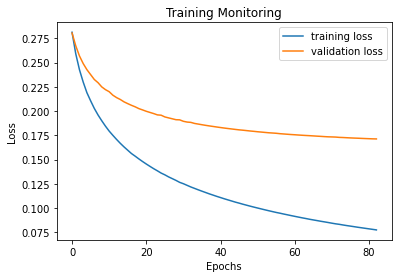

In [28]:
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(loss_tr_count)),loss_tr_count,label='training loss')
plt.plot(range(len(dev_loss_count)),dev_loss_count,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

**Conclusion:** Overfitting
* **Discuss Overfitting:** The loss on the validation set is twice the loss on the training set, which indicates that the model overfits the training set.
* **Discuss Underfitting:** Both the loss on the validation set and the loss on the training set are kept at very small values. Thus there is no underfit.

Compute accuracy, precision, recall and F1-scores:

In [29]:
# Get test output from the model
preds_te_count = predict_class(X_te_count,w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388


Finally, print the top-10 words for the negative and positive class respectively.

In [30]:
# Stort the index by weight parameters 
sorted_index = w_count.copy().flatten().argsort()
top_neg_ngram = [vocab[i] for i in sorted_index[:10]]
print("Top-10 negative words:")
print(top_neg_ngram)

Top-10 negative words:
['bad', 'only', 'unfortunately', 'worst', 'script', 'why', 'boring', 'plot', 'any', 'nothing']


In [31]:
# Stort the index by weight parameters
top_pos_ngram = [vocab[i] for i in sorted_index[-10:][::-1]]
print("Top-10 positive words:")
print(top_pos_ngram)

Top-10 positive words:
['great', 'well', 'seen', 'fun', 'also', 'many', 'life', 'both', 'world', 'movies']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

**Conclusion:** No, although it works, it may not work well.. 
* **Data distribution:** Although the model can be used in other domain, the learned parameters are not. The data in the training set should be independent and identically distributed. However, after switching domains, the data may never appear in the training set, which means that the data set in this field is distributed in the training set as 0. This can lead to poor performance.
* **Vocabulary Corpus:** New words appearing in different domain can also lead to poor performance.

According to the existing training models and parameters, the classifier can only extract as important features the same as the training set. Extracting new features can be obtained by retraining the classifier. However, there are many words that have positive or negative emotional color. These words are especially important for classifiers even in different domain. For example, ‘great’ itself means positive, ‘bad’ itself means negative

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [32]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0006, 
                         alpha=0.0001, 
                         epochs=50)

Epoch: 0| Training loss: 0.224120| Validation loss: 0.252379
Epoch: 1| Training loss: 0.173527| Validation loss: 0.231832
Epoch: 2| Training loss: 0.146122| Validation loss: 0.218790
Epoch: 3| Training loss: 0.127485| Validation loss: 0.210185
Epoch: 4| Training loss: 0.113679| Validation loss: 0.202728
Epoch: 5| Training loss: 0.103069| Validation loss: 0.197134
Epoch: 6| Training loss: 0.094403| Validation loss: 0.192620
Epoch: 7| Training loss: 0.087173| Validation loss: 0.189145
Epoch: 8| Training loss: 0.081058| Validation loss: 0.186442
Epoch: 9| Training loss: 0.075826| Validation loss: 0.182934
Epoch: 10| Training loss: 0.071235| Validation loss: 0.180977
Epoch: 11| Training loss: 0.067270| Validation loss: 0.178854
Epoch: 12| Training loss: 0.063653| Validation loss: 0.177424
Epoch: 13| Training loss: 0.060475| Validation loss: 0.175679
Epoch: 14| Training loss: 0.057581| Validation loss: 0.174263
Epoch: 15| Training loss: 0.054981| Validation loss: 0.172982
Epoch: 16| Trainin

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

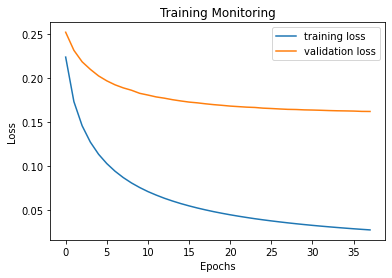

In [33]:
# Plot loss
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(trl)),trl,label='training loss')
plt.plot(range(len(devl)),devl,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

**Conclusion:** Overfitting
* **Discuss Overfitting:** The loss on the validation set is 8 times larger than the loss on the training set, which indicates that the model overfits the training set.
* **Discuss Underfitting:** Both the loss on the validation set and the loss on the training set are kept at very small values. Thus there is no underfit.

Compute accuracy, precision, recall and F1-scores:

In [34]:
# Evaluate on test dataset
preds_te = predict_class(X_te_tfidf,w_tfidf)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.855
Precision: 0.855
Recall: 0.855
F1-Score: 0.855


Print top-10 most positive and negative words:

In [35]:
# Stort the index by weight parameters 
sorted_index = w_tfidf.copy().flatten().argsort()
top_neg_ngram = [vocab[i] for i in sorted_index[:10]]
print("Top-10 negative words:")
print(top_neg_ngram)

Top-10 negative words:
['bad', 'worst', 'boring', 'supposed', 'unfortunately', 'script', 'nothing', 'why', 'waste', 'plot']


In [36]:
# Stort the index by weight parameters 
top_pos_ngram = [vocab[i] for i in sorted_index[-10:][::-1]]
print("Top-10 positive words:")
print(top_pos_ngram)

Top-10 positive words:
['great', 'fun', 'hilarious', 'terrific', 'memorable', 'perfectly', 'overall', 'truman', 'definitely', 'seen']


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

**1. Choose Model Hyperparameters:**

To choose hyperparameters, like learning rate and regularisation strength alpha, thay can be found by drawing a line chart. Basically, use grid search to find the optimal hyperparameters. This method is simple but time-consuming. Ideally, cross-validation should be used to screen the optimal hyperparameters, but because the training and validation sets have been divided, cross-validation is not very convenient.(Code of grid search is given below)

**note:** The following hyperparameter optimization has limitations. Only a fixed training set and verification set are used. Ideally, it should be divided into multiple groups and cross-validation should be used. Specifically, Leave-One-Out Cross-Validation ([LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation)) is used when drawing.

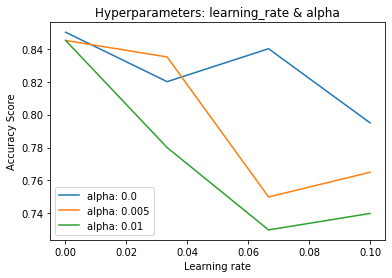

In [37]:
# Run a training on a set of hyperparameters
def get_score(lr,alpha):
    w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=lr, 
                         alpha=alpha, 
                         epochs=100,
                         print_progress=False)
    preds_dev = predict_class(X_dev_tfidf,w_tfidf)
    return accuracy_score(Y_dev,preds_dev)

# Initial hyperparameters
fig = plt.figure()
lrs_num = 4
alphas_num = 3
lrs = np.linspace(0.0001,0.1,lrs_num)
alphas = np.linspace(0.,0.01,alphas_num)

# Run trainings on different sets of hyperparameters
for i in range(alphas_num):
    alpha = alphas[i]
    tmp = list()
    for j in range(lrs_num):
        lr = lrs[j]
        score = get_score(lr, alpha)
        tmp.append(score)
    plt.plot(lrs,tmp,label='alpha: {}'.format(alpha))

plt.xlabel('Learning rate')
plt.ylabel('Accuracy Score')
plt.title('Hyperparameters: learning_rate & alpha')

plt.legend()
plt.show()

As shown in the figure above, the X axis represents the learning rate, and the Y axis refers to the accuracy rate. And different colored polylines indicate different regularisation strength. 

When the learning rate is increased, the model will not fully converge, and it will continue to oscillate around the lowest point. The performance of the model will also decrease. As shown in the above figure, after the three polylines increase the learning rate, the accuracy of the model will be different decline. 

However, as the learning rate continues to increase again, the performance of the model will increase, mainly because there are other local minimum points in the direction of the gradient, and the model will converge to other local minimum values. (Think of the existence of many low-lying areas in the valley--the local minimum points, although the optimal solution is the global minimum point).

**2. Relationship between training epochs and learning rate:** 

In simple terms, the smaller the learning rate, the more epochs are needed. But there are some special cases. **Epoch:** If there are too few epochs, there may be insufficient training, resulting in underfitting. If there are too many epochs, the loss may have already converged, and the extra epochs are too wasteful of time.
**Learning rate:** Too large a learning rate will not only cause data overflow, but also cause the loss function to fail to converge. Too small a learning rate will consume training time. At the same time, the convex optimization problem should also be considered, otherwise, the loss function may fall into a local minimum. It can also be observed from the line chart below.

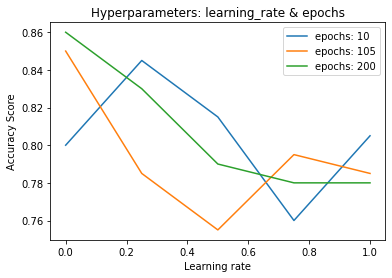

In [38]:
# Run a training on a set of hyperparameters
def get_score(lr,epoch):
    w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=lr, 
                         alpha=0.0001, 
                         epochs=epoch,
                         print_progress=False)
    preds_dev = predict_class(X_dev_tfidf,w_tfidf)
    return accuracy_score(Y_dev,preds_dev)

# Initial hyperparameters
fig = plt.figure()
lrs_num = 5
epochs_num = 3
lrs = np.linspace(0.0001,1,lrs_num)
epochs = np.linspace(10,200,epochs_num,dtype=int)

# Run trainings on different sets of hyperparameters
for i in range(epochs_num):
    epoch = epochs[i]
    tmp = list()
    for j in range(lrs_num):
        lr = lrs[j]
        score = get_score(lr,epoch)
        tmp.append(score)
    plt.plot(lrs,tmp,label='epochs: {}'.format(epoch))
    
plt.xlabel('Learning rate')
plt.ylabel('Accuracy Score')
plt.title('Hyperparameters: learning_rate & epochs')

plt.legend()
plt.show()

Observing the above figure, when the epochs is not enough which refers to underfitting, such as the start of the blue polyline, increasing the learning rate can greatly help the model to converge, thereby improving the model performance (accuracy). Increasing the learning rate may not converge to the lowest point, as shown by the green and orange lines in the figure. However, when it is increased again, it may converge to the new local minimum point, just like the orange and blue lines whose accuracy started to increase again with the learning rate around 0.7.

**3. Regularisation Strength:** 

Regularization prevents the classifier from overfitting by limiting the number of parameters. The regularization intensity refers to the size of the penalty. The higher the regularization intensity, the more limited the number of parameters. However, when the regularization intensity is too high, the loss function may not converge.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.831   |0.840   |0.835   |
| BOW-tfidf  |0.855   |0.855   |0.855   |




# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [39]:
# Load dateset
Data = FileLoader('data_topic',names=['label','text'])

data_tr = Data.train
data_te = Data.test
data_dev = Data.dev

Finish loading:
	train.csv
	test.csv
	dev.csv


In [40]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [41]:
X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

In [42]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['reuters', 'said', 'tuesday', 'new', 'wednesday', 'after', 'athens', 'ap', 'monday', 'first', 'their', 'us', 'olympic', 'york', ('new', 'york'), 'two', 'over', 'but', 'oil', 'inc', 'more', 'prices', 'year', 'company', 'world', 'gt', 'lt', 'than', 'aug', 'about', 'had', 'one', 'united', 'out', 'sunday', 'against', 'up', 'quot', 'into', 'fullquote', 'second', 'last', 'stocks', 'team', 'president', 'gold', 'percent', 'iraq', 'three', 'when', 'greece', 'night', ('york', 'reuters'), ('new', 'york', 'reuters'), 'time', 'not', 'no', 'games', 'yesterday', 'home', 'olympics', 'washington', 'states', 'off', ('united', 'states'), 'google', ('oil', 'prices'), 'day', 'public', 'billion', 'record', ('athens', 'reuters'), 'week', 'win', 'all', 'men', 'government', 'won', ('said', 'tuesday'), 'najaf', 'american', 'years', 'officials', 'today', 'city', 'would', 'shares', 'offering', 'people', 'final', 'medal', 'minister', 'afp', 'corp', 'sales', 'million', 'back', 'four', 'investor', 'com']

[('

In [43]:
vocab_tr, df_tr, ngram_counts_tr = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(X_dev_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
vocab_te, df_te, ngram_counts_te = get_vocab(X_te_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

X_tr_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_tr_raw]
X_te_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_te_raw]
X_dev_ngram = [extract_ngrams(line,ngram_range=(1,3),stop_words=stop_words) for line in X_dev_raw]

X_tr_count = vectorise(X_tr_ngram, vocab_tr)
X_te_count = vectorise(X_te_ngram, vocab_tr)
X_dev_count = vectorise(X_dev_ngram, vocab_tr)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [44]:
def softmax(z):
    
    '''Calculate softmax results
    
    In order to avoid data overflow, the corresponding data boundary is added.
    Since np.exp() is a `np.float64` operation function, so we need to avoid overflow.
    It is easy to find out the boundary of `np.float64` by calling np.finfo(np.float64).
    Usually, it should be written as `np.minimum(np.exp(z),np.finfo(np.float64).max)`,
    but I prefer to written inside the exp function, since it somehow can be faster.
    For the input of np.exp(), it should not be greater than 709.782 to ensure that the
    output will not overflow.
    
    Returns:
        z: the same size of z.
    '''
    
    z = z.copy()
    z = np.minimum(z,709.782)
    smax = np.exp(z) / np.sum(np.exp(z),axis=1,keepdims=True)
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [45]:
def predict_proba(X, weights):
    
    preds_proba = X.dot(weights.T)
    assert preds_proba.shape == (X.shape[0],weights.shape[0])
    
    return softmax(preds_proba)

In [46]:
def predict_class(X, weights):
    
    preds_class = np.argmax(predict_proba(X, weights),axis=1)+1
    
    assert preds_class.shape == (X.shape[0],)
    
    return preds_class

Toy example and expected functionality of the functions above:

In [47]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [48]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [49]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [50]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    '''1. Calculate the probability
       2. Calculate the Euclidean distance between label and probability
       3. Calculate the average distance
       
    Here I use `esp` to represent the smallest data unit of the data type. 
    The main function of `esp` is to ensure the rationality of arithmetic 
    operations. For example, in the division operation, add `esp` to the 
    denominator to ensure that the denominator is not 0, and it does not 
    affect the data result. This is the habit I developed when I wrote Matlab
    in my undergraduate period. `esp` is more common in Matlab.
    
    Args:
        eps: the minimum value in the current data type. Used to ensure
            that the input of the log function is greater than 0.
        preds_proba: Probability of each data, the same
            size of input data.(X.shape[0])

    Returns:
        l: Used to save losses and calculate the average at the end
    '''
    
    assert Y.shape[0] == X.shape[0]
    eps = np.finfo(np.float64).eps
    preds_proba = predict_proba(X, weights)
    Y = np.eye(weights.shape[0],weights.shape[0])[Y-1].reshape(X.shape[0],weights.shape[0])
    l1 = -np.sum(Y*np.log10(preds_proba+eps),1) 
    l2 = alpha*np.sum(np.multiply(weights,weights))
    l=np.mean(l1)+l2/X.shape[0]
    
    return l

In [51]:
def gradient(X, Y, weights, alpha=0.00001):
    
    '''Only calculate the gradient of the corresponding position
    
    Args: 
        m: the total number of the dataset sample.
        h: an numpy array of prediction corresponding to the
            dataset points. Shape (#dataset,1)
            
    Returns:
        dw: the corresponding gradient. Shape the same with 
            weight.
    '''
    
    m = len(X)
    Y_c = Y.copy()
    Y = np.eye(weights.shape[0],weights.shape[0])[Y-1].reshape(X.shape[0],weights.shape[0])
    h = predict_proba(X, weights)
    dw = -np.dot(np.sum(Y-Y*h,axis=1),X) + 2*alpha*weights[(Y_c-1).item()]
    
    return dw/m

Finally you need to modify SGD to support the categorical cross entropy loss:

In [52]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # Stage 1: Init weights
    weights = np.zeros((num_classes,X_tr.shape[1]))
    
    # Stage 2: Init stochastic value
    idx_list = np.array(range(X_tr.shape[0]))
    
    # Stage 3: Training
    for epoch in range(epochs):
        np.random.shuffle(idx_list) # disorder dataset
        for i in idx_list:
            X_tr_i, Y_tr_i = X_tr[i].reshape(1,-1),Y_tr[i].reshape(1,-1) # get a single data pair
            dw = gradient(X_tr_i, Y_tr_i, weights, alpha) # gradient
            weights[(Y_tr_i-1).item()] -= lr*dw # update       
        loss_dev = categorical_loss(X_dev, Y_dev, weights, num_classes, alpha)
        loss_tr = categorical_loss(X_tr, Y_tr, weights, num_classes, alpha)

        # Add history
        training_loss_history.append(loss_tr)
        validation_loss_history.append(loss_dev)
        
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch,loss_tr,loss_dev))
            
        if epoch >1 and abs(validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [53]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.0001, 
                                             epochs=200)

Epoch: 0| Training loss: 0.410661| Validation loss: 0.439247
Epoch: 1| Training loss: 0.368637| Validation loss: 0.410634
Epoch: 2| Training loss: 0.337847| Validation loss: 0.387376
Epoch: 3| Training loss: 0.313983| Validation loss: 0.368050
Epoch: 4| Training loss: 0.294851| Validation loss: 0.351723
Epoch: 5| Training loss: 0.279054| Validation loss: 0.337735
Epoch: 6| Training loss: 0.265740| Validation loss: 0.325617
Epoch: 7| Training loss: 0.254328| Validation loss: 0.315016
Epoch: 8| Training loss: 0.244400| Validation loss: 0.305661
Epoch: 9| Training loss: 0.235646| Validation loss: 0.297329
Epoch: 10| Training loss: 0.227854| Validation loss: 0.289844
Epoch: 11| Training loss: 0.220857| Validation loss: 0.283103
Epoch: 12| Training loss: 0.214522| Validation loss: 0.276969
Epoch: 13| Training loss: 0.208742| Validation loss: 0.271358
Epoch: 14| Training loss: 0.203437| Validation loss: 0.266208
Epoch: 15| Training loss: 0.198552| Validation loss: 0.261471
Epoch: 16| Trainin

Plot training and validation process and explain if your model overfit, underfit or is about right:

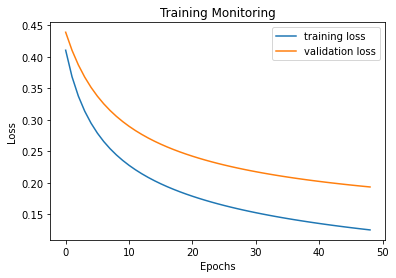

In [54]:
# Plot loss
%matplotlib inline
fig = plt.figure()
plt.plot(range(len(loss_tr_count)),loss_tr_count,label='training loss')
plt.plot(range(len(dev_loss_count)),dev_loss_count,label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring')

plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-scores:

In [55]:
# Evaluate on test dataset
preds_te = predict_class(X_te_count,w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8466666666666667
Precision: 0.8508050575599119
Recall: 0.8466666666666667
F1-Score: 0.8459211261526534


Print the top-10 words for each class respectively.

In [56]:
# Stort the index by weight parameters 
sorted_index = w_count.copy().argsort()[:,-10:][:,::-1]
for class_i in range(len(sorted_index)):
    print("Class {}:".format(class_i+1))
    top_neg_ngram = [vocab[i] for i in sorted_index[class_i]]
    print(top_neg_ngram,'\n')

Class 1:
['said', 'tuesday', 'reuters', 'new', 'ap', 'after', 'monday', 'wednesday', 'athens', 'their'] 

Class 2:
['athens', 'ap', 'reuters', 'tuesday', 'olympic', 'after', 'first', 'team', 'new', 'wednesday'] 

Class 3:
['reuters', 'said', 'new', 'tuesday', 'oil', 'company', 'after', 'wednesday', 'prices', 'us'] 



### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

**1. Choose Model Hyperparameters:**

To choose hyperparameters, like learning rate and regularisation strength alpha, thay can be found by drawing a line chart. Basically, use grid search to find the optimal hyperparameters. This method is simple but time-consuming. Ideally, cross-validation should be used to screen the optimal hyperparameters, but because the training and validation sets have been divided, cross-validation is not very convenient.(Code of grid search is given below)

**note:** The following hyperparameter optimization has limitations. Only a fixed training set and verification set are used. Ideally, it should be divided into multiple groups and cross-validation should be used. Specifically, Leave-One-Out Cross-Validation ([LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation)) is used when drawing.

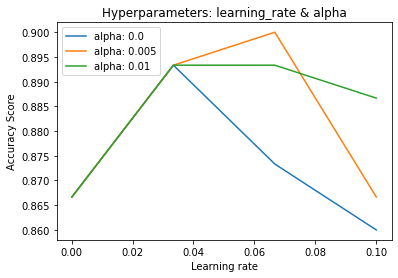

In [57]:
# Run a training on a set of hyperparameters
def get_score(lr,alpha):
    w, trl, devl = SGD(X_tr_count, Y_tr, 
                         X_dev=X_dev_count, 
                         Y_dev=Y_dev, 
                         num_classes=3,
                         lr=lr, 
                         alpha=alpha, 
                         epochs=200,
                         print_progress=False)
    preds_dev = predict_class(X_dev_count,w)
    return accuracy_score(Y_dev,preds_dev)

# Initial hyperparameters
fig = plt.figure()
lrs_num = 4
alphas_num = 3
lrs = np.linspace(0.0001,0.1,lrs_num)
alphas = np.linspace(0.,0.01,alphas_num)

# Run trainings on different sets of hyperparameters
for i in range(alphas_num):
    alpha = alphas[i]
    tmp = list()
    for j in range(lrs_num):
        lr = lrs[j]
        score = get_score(lr, alpha)
        tmp.append(score)
    plt.plot(lrs,tmp,label='alpha: {}'.format(alpha))

plt.xlabel('Learning rate')
plt.ylabel('Accuracy Score')
plt.title('Hyperparameters: learning_rate & alpha')

plt.legend()
plt.show()

As can be seen from the above figure, appropriately increasing the learning rate can make the model converge better and the model effect is better. After the three polylines increase the learning rate, they all reach their peak accuracy rates. 

However, when the learning rate is increased again, the effectiveness of the model is reduced. This is mainly because the excessive learning rate will cause the value of the loss function to continuously oscillate around the local minimum point and fail to converge to a lower point.

As for the regularisation strength, there is little difference before the model has converged to the lowest point. When the learning rate reaches about 0.03, the effect of regularization begins to appear. Compared with the binary classification problem, the regularization effect is more obvious in the case of multiple classifications. For example, in the figure above, when the learning rate is around 0.07, the accuracy of the orange and green polylines is higher than that of the blue polylines, where the regularization coefficient of the blue polylines is 0. In addition, the model corresponding to the orange line performs better than the model corresponding to the green line. This shows that the regularization coefficient needs to be appropriate. If it is too large or too small, it will reduce the generalization ability of the model.

**2. Relationship between training epochs and learning rate:** 

In simple terms, the smaller the learning rate, the more epochs are needed. But there are some special cases. **Epoch:** If there are too few epochs, there may be insufficient training, resulting in underfitting. If there are too many epochs, the loss may have already converged, and the extra epochs are too wasteful of time.
**Learning rate:** Too large a learning rate will not only cause data overflow, but also cause the loss function to fail to converge. Too small a learning rate will consume training time. At the same time, the convex optimization problem should also be considered, otherwise, the loss function may fall into a local minimum. It can also be observed from the line chart below.

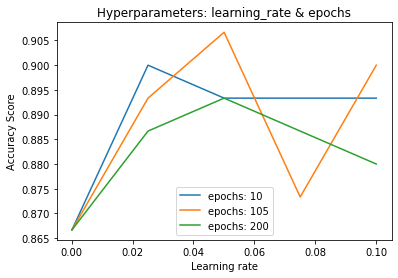

In [58]:
# Run a training on a set of hyperparameters
def get_score(lr,epoch):
    w, trl, devl = SGD(X_tr_count, Y_tr, 
                         X_dev=X_dev_count, 
                         Y_dev=Y_dev, 
                         num_classes=3,
                         lr=lr, 
                         alpha=0.005, 
                         epochs=epoch,
                         print_progress=False)
    preds_dev = predict_class(X_dev_count,w)
    return accuracy_score(Y_dev,preds_dev)

# Initial hyperparameters
fig = plt.figure()
lrs_num = 5
epochs_num = 3
lrs = np.linspace(0.0001,0.1,lrs_num)
epochs = np.linspace(10,200,epochs_num,dtype=int)

# Run trainings on different sets of hyperparameters
for i in range(epochs_num):
    epoch = epochs[i]
    tmp = list()
    for j in range(lrs_num):
        lr = lrs[j]
        score = get_score(lr,epoch)
        tmp.append(score)
    plt.plot(lrs,tmp,label='epochs: {}'.format(epoch))
    
plt.xlabel('Learning rate')
plt.ylabel('Accuracy Score')
plt.title('Hyperparameters: learning_rate & epochs')

plt.legend()
plt.show()

Observing the above figure, when the epochs is not enough which refers to underfitting, such as the start of all three polylines, increasing the learning rate can greatly help the model to converge, thereby improving the model performance (accuracy). Increasing the learning rate may not converge to the lowest point, as shown by all three lines in the figure. After continuing to increase the learning rate, the performance of all the models corresponding to the line has decreased to varying degrees. However, when it is increased again, it may converge to the new local minimum point, just like the orange line whose accuracy started to increase again with the learning rate around 0.1 and reach the performance peak again.

**3. Regularisation Strength:** 

Regularization prevents the classifier from overfitting by limiting the number of parameters. The regularization intensity refers to the size of the penalty. The higher the regularization intensity, the more limited the number of parameters. However, when the regularization intensity is too high, the loss function may not converge.

### Now evaluate BOW-tfidf...

In [59]:
idfs_tr = get_idfs(vocab_tr,df_tr,len(X_tr_raw))
idfs_te = get_idfs(vocab_tr,df_te,len(X_te_raw))
idfs_dev = get_idfs(vocab_tr,df_dev,len(X_dev_raw))

In [60]:
X_tr_tfidf = X_tr_count*idfs_tr
X_te_tfidf = X_te_count*idfs_te
X_dev_tfidf = X_dev_count*idfs_dev

In [61]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_tfidf, Y_tr, 
                                             X_dev=X_dev_tfidf, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch: 0| Training loss: 0.455029| Validation loss: 0.466185
Epoch: 1| Training loss: 0.436180| Validation loss: 0.456380
Epoch: 2| Training loss: 0.419637| Validation loss: 0.447402
Epoch: 3| Training loss: 0.404834| Validation loss: 0.439071
Epoch: 4| Training loss: 0.391402| Validation loss: 0.431271
Epoch: 5| Training loss: 0.379117| Validation loss: 0.423931
Epoch: 6| Training loss: 0.367810| Validation loss: 0.416998
Epoch: 7| Training loss: 0.357359| Validation loss: 0.410435
Epoch: 8| Training loss: 0.347663| Validation loss: 0.404208
Epoch: 9| Training loss: 0.338640| Validation loss: 0.398290
Epoch: 10| Training loss: 0.330215| Validation loss: 0.392653
Epoch: 11| Training loss: 0.322334| Validation loss: 0.387282
Epoch: 12| Training loss: 0.314941| Validation loss: 0.382153
Epoch: 13| Training loss: 0.307993| Validation loss: 0.377252
Epoch: 14| Training loss: 0.301448| Validation loss: 0.372562
Epoch: 15| Training loss: 0.295273| Validation loss: 0.368071
Epoch: 16| Trainin

In [62]:
# Evaluate on test dataset
preds_te = predict_class(X_te_tfidf,w_count).reshape(-1,1)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8855555555555555
Precision: 0.8872497496851856
Recall: 0.8855555555555555
F1-Score: 0.884978503362328


In [63]:
# Stort the index by weight parameters 
sorted_index = w_count.copy().argsort()[:,-10:][:,::-1]
for class_i in range(len(sorted_index)):
    print("Class {}:".format(class_i+1))
    top_neg_ngram = [vocab[i] for i in sorted_index[class_i]]
    print(top_neg_ngram, '\n')

Class 1:
['said', 'tuesday', 'afp', 'ap', 'monday', 'president', 'reuters', 'after', 'their', 'people'] 

Class 2:
['athens', 'olympic', 'ap', 'team', 'first', 'games', 'olympics', 'quot', 'night', 'two'] 

Class 3:
['company', 'oil', 'new', 'reuters', 'said', 'prices', 'inc', 'us', 'tuesday', 'billion'] 



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.850   |0.846   |0.845   |
| BOW-tfidf  |0.887   |0.885   |0.884   |
